In [1]:
import os    
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

from scene import GaussianModel, Scene

colmap_path = "C:/Users/arpit/Desktop/003"  #fframes"

from arguments import ModelParams
from argparse import ArgumentParser
import sys
from gaussian_renderer import render
from arguments import PipelineParams, OptimizationParams

sys.argv = f"x --source_path {colmap_path} -r 2".split()

parser = ArgumentParser(description="Training script parameters")
dataset = ModelParams(parser)
args = parser.parse_args(sys.argv[1:])
temp = dataset.extract(args)
gaussians = GaussianModel(sh_degree=3)
scene = Scene(temp, gaussians)

cams = scene.getTrainCameras()
import numpy as np

c:\Users\arpit\.conda\envs\gaussian_splatting\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Reading camera 34/34
Converting point3d.bin to .ply, will happen only the first time you open the scene.
Loading Training Cameras
Loading Test Cameras
Number of points at initialisation :  6091


In [2]:
cams[0].image_name

'018_0001.png'

In [12]:
import gc
gc.collect()

129

In [3]:
resolution = round(1920/(1.0 * args.resolution)), round(1080/(1.0 * args.resolution))
resolution

(960, 540)

In [7]:
from scene.cameras import Displace_Camera

name = '003_0002.png'

new_cam = Displace_Camera(resolution=(960, 540), R=cams[0].R, T=cams[0].T, 
                          FoVx=cams[0].FoVx, FoVy=cams[0].FoVy, depth_params=None,
                          image_width=960, image_height=540, invdepthmap=None, 
                          data_device=args.data_device, train_test_exp=args.train_test_exp, 
                          is_test_dataset=False, is_test_view=False)

In [14]:
cams[0].projection_matrix, new_cam.projection_matrix

(tensor([[ 8.9217e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  1.5861e+01,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  1.0001e+00,  1.0000e+00],
         [ 0.0000e+00,  0.0000e+00, -1.0001e-02,  0.0000e+00]], device='cuda:0'),
 tensor([[ 8.9217e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  1.5861e+01,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  1.0001e+00,  1.0000e+00],
         [ 0.0000e+00,  0.0000e+00, -1.0001e-02,  0.0000e+00]], device='cuda:0'))

In [17]:
import gc
gc.collect()

21

In [14]:
cams[0].original_image.shape

torch.Size([3, 540, 960])

In [2]:
rots = np.array([x.R - cams[0].R for x in cams])
np.mean(rots, axis=0)

array([[-1.01927034e-05,  1.97730337e-04, -5.10080816e-04],
       [-2.00388705e-04, -1.41528002e-04, -5.66120907e-03],
       [ 5.17760976e-04,  5.66302188e-03, -1.44409943e-04]])

In [4]:
trans = np.array([x.T - cams[0].T for x in cams])
np.mean(trans, axis=0)

array([-0.08089646, -0.96109729,  0.54642543])

In [5]:
auds = np.load("C:/Users/arpit/Desktop/M005_front/neutral/level_1/input/audio_features/004.npy")
auds.shape

(137, 1707)

In [6]:
labels = np.array([x.T - cams[0].T for x in cams])
labels.shape

(137, 3)

In [7]:
labels[4]

array([-0.63948494, -2.77807441,  0.40886779])

In [15]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    auds, labels.reshape(137, -1), test_size=0.3, random_state=42)

In [16]:
from sklearn.neural_network import MLPRegressor

mlp = MLPRegressor(random_state=42)

mlp.fit(X_train, y_train)

MLPRegressor(random_state=42)

In [17]:
mlp.score(X_train, y_train), mlp.score(X_test, y_test)

(0.9994154128957885, -0.7834447109694905)

In [8]:
import gc
gc.collect()

210

### Check Raster from Trained Gaussians

In [5]:
import numpy
from plyfile import PlyData, PlyElement

with open("C:/Users/arpit/Desktop/fframes_op/point_cloud/iteration_7000/point_cloud.ply", 'rb') as f:
    plydata = PlyData.read(f)


In [6]:
plydata.elements[0].count

45074

In [1]:
import os    
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

In [ ]:
from scene import GaussianModel, Scene

colmap_path = "C:/Users/arpit/Desktop/M005_front/neutral/level_1/sparse_0_final"
#colmap_path = "C:/Users/arpit/Desktop/M005_021_front"

from arguments import ModelParams
from argparse import ArgumentParser
import sys
from gaussian_renderer import render
from arguments import PipelineParams, OptimizationParams

sys.argv = f"x --source_path {colmap_path} -r 8".split()

parser = ArgumentParser(description="Training script parameters")
dataset = ModelParams(parser)
args = parser.parse_args(sys.argv[1:])
temp = dataset.extract(args)
gaussians = GaussianModel(sh_degree=3)
scene = Scene(temp, gaussians)

front_cams = [cam for cam in scene.getTrainCameras() if cam.image_name.startswith('front')]

In [2]:
cam_names = [cam.image_name for cam in scene.getTrainCameras()]
len(cam_names)

3483

In [7]:
# for sparse/0

from collections import Counter

sorted(Counter([x[:3] for x in cam_names]).items())

[('001', 136),
 ('002', 85),
 ('003', 34),
 ('004', 137),
 ('005', 73),
 ('006', 89),
 ('007', 200),
 ('008', 80),
 ('009', 102),
 ('010', 136),
 ('011', 110),
 ('012', 133),
 ('013', 125),
 ('014', 169),
 ('015', 81),
 ('016', 83),
 ('017', 171),
 ('018', 167),
 ('019', 96),
 ('020', 92),
 ('021', 101),
 ('022', 73),
 ('023', 100),
 ('024', 120),
 ('025', 115),
 ('026', 130),
 ('027', 163),
 ('028', 147),
 ('029', 77),
 ('030', 158)]

In [ ]:
# for sparse/1

from collections import Counter

Counter([x[:3] for x in cam_names])

Counter({'033': 131,
         '034': 99,
         '035': 111,
         '032': 106,
         '037': 117,
         '036': 188,
         '031': 95})

In [20]:
import gc
gc.collect()

21

In [22]:
#opt = opt1.extract(args)
#pipe = pipe1.extract(args)

#opt1 = OptimizationParams(parser)
pipe1 = PipelineParams(parser)

gaussians.load_ply("C:/Users/arpit/Desktop/M005_no_densify/point_cloud/iteration_30000/point_cloud.ply")

In [28]:
import torch

bg_color = [1, 1, 1] if temp.white_background else [0, 0, 0]
background = torch.tensor(bg_color, dtype=torch.float32, device="cuda")

net_image = render(relcam,
                   gaussians, pipe1, background, 
                   scaling_modifier=1.0, 
                   use_trained_exp=temp.train_test_exp)["render"]

In [29]:
type(net_image)

torch.Tensor

In [30]:
net_image.shape

torch.Size([3, 540, 960])

In [31]:
img = net_image.permute(1, 2, 0).cpu().detach().numpy()
img.shape

(540, 960, 3)

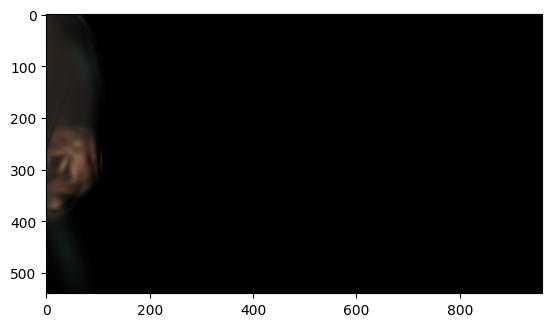

In [32]:
import os    
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True' # else imshow will crash kernel

import matplotlib.pyplot as plt


plt.imshow(img)

In [36]:
cam2[0].image_name

'front_neutral_002_002.png'

In [37]:
import gc
gc.collect()

267

In [ ]:
gaussians._xyz.shape, gaussians._features_dc.shape, gaussians._features_rest.shape

(torch.Size([4085, 3]), torch.Size([4085, 1, 3]), torch.Size([4085, 15, 3]))

In [ ]:
gaussians._scaling.shape, gaussians._rotation.shape, gaussians._opacity.shape

(torch.Size([4085, 3]), torch.Size([4085, 4]), torch.Size([4085, 1]))

In [ ]:
gaussians.__dict__.keys()

dict_keys(['active_sh_degree', 'max_sh_degree', '_xyz', '_features_dc', '_features_rest', '_scaling', '_rotation', '_opacity', 'max_radii2D', 'xyz_gradient_accum', 'denom', 'optimizer', 'percent_dense', 'spatial_lr_scale', 'scaling_activation', 'scaling_inverse_activation', 'covariance_activation', 'opacity_activation', 'inverse_opacity_activation', 'rotation_activation', 'exposure_mapping', 'pretrained_exposures', '_exposure'])

### COLMAP Images and Camera BINS

In [2]:
import struct
import numpy as np
import collections

BaseImage = collections.namedtuple(
    "Image", ["id", "qvec", "tvec", "camera_id", "name", "xys", "point3D_ids"])

def qvec2rotmat(qvec):
    return np.array([
        [1 - 2 * qvec[2]**2 - 2 * qvec[3]**2,
         2 * qvec[1] * qvec[2] - 2 * qvec[0] * qvec[3],
         2 * qvec[3] * qvec[1] + 2 * qvec[0] * qvec[2]],
        [2 * qvec[1] * qvec[2] + 2 * qvec[0] * qvec[3],
         1 - 2 * qvec[1]**2 - 2 * qvec[3]**2,
         2 * qvec[2] * qvec[3] - 2 * qvec[0] * qvec[1]],
        [2 * qvec[3] * qvec[1] - 2 * qvec[0] * qvec[2],
         2 * qvec[2] * qvec[3] + 2 * qvec[0] * qvec[1],
         1 - 2 * qvec[1]**2 - 2 * qvec[2]**2]])

class Image(BaseImage):
    def qvec2rotmat(self):
        return qvec2rotmat(self.qvec)

def read_next_bytes(fid, num_bytes, format_char_sequence, endian_character="<"):
    """Read and unpack the next bytes from a binary file.
    :param fid:
    :param num_bytes: Sum of combination of {2, 4, 8}, e.g. 2, 6, 16, 30, etc.
    :param format_char_sequence: List of {c, e, f, d, h, H, i, I, l, L, q, Q}.
    :param endian_character: Any of {@, =, <, >, !}
    :return: Tuple of read and unpacked values.
    """
    data = fid.read(num_bytes)
    return struct.unpack(endian_character + format_char_sequence, data)


def read_extrinsics_binary(path_to_model_file):
    """
    see: src/base/reconstruction.cc
        void Reconstruction::ReadImagesBinary(const std::string& path)
        void Reconstruction::WriteImagesBinary(const std::string& path)
    """
    images = {}
    with open(path_to_model_file, "rb") as fid:
        num_reg_images = read_next_bytes(fid, 8, "Q")[0]
        image_ids = []
        for _ in range(num_reg_images):
            binary_image_properties = read_next_bytes(
                fid, num_bytes=64, format_char_sequence="idddddddi")
            image_id = binary_image_properties[0]
            qvec = np.array(binary_image_properties[1:5])
            tvec = np.array(binary_image_properties[5:8])
            camera_id = binary_image_properties[8]
            image_name = ""
            current_char = read_next_bytes(fid, 1, "c")[0]
            while current_char != b"\x00":   # look for the ASCII 0 entry
                image_name += current_char.decode("utf-8")
                current_char = read_next_bytes(fid, 1, "c")[0]
            num_points2D = read_next_bytes(fid, num_bytes=8,
                                           format_char_sequence="Q")[0]
            x_y_id_s = read_next_bytes(fid, num_bytes=24*num_points2D,
                                       format_char_sequence="ddq"*num_points2D)
            xys = np.column_stack([tuple(map(float, x_y_id_s[0::3])),
                                   tuple(map(float, x_y_id_s[1::3]))])
            point3D_ids = np.array(tuple(map(int, x_y_id_s[2::3])))

            image_ids.append(image_id)
        
        return image_ids 
        #    images[image_id] = Image(
        #        id=image_id, qvec=qvec, tvec=tvec,
        #        camera_id=camera_id, name=image_name,
        #        xys=xys, point3D_ids=point3D_ids)
    #return images


In [8]:
CameraModel = collections.namedtuple(
    "CameraModel", ["model_id", "model_name", "num_params"])
Camera = collections.namedtuple(
    "Camera", ["id", "model", "width", "height", "params"])
BaseImage = collections.namedtuple(
    "Image", ["id", "qvec", "tvec", "camera_id", "name", "xys", "point3D_ids"])
Point3D = collections.namedtuple(
    "Point3D", ["id", "xyz", "rgb", "error", "image_ids", "point2D_idxs"])
CAMERA_MODELS = {
    CameraModel(model_id=0, model_name="SIMPLE_PINHOLE", num_params=3),
    CameraModel(model_id=1, model_name="PINHOLE", num_params=4),
    CameraModel(model_id=2, model_name="SIMPLE_RADIAL", num_params=4),
    CameraModel(model_id=3, model_name="RADIAL", num_params=5),
    CameraModel(model_id=4, model_name="OPENCV", num_params=8),
    CameraModel(model_id=5, model_name="OPENCV_FISHEYE", num_params=8),
    CameraModel(model_id=6, model_name="FULL_OPENCV", num_params=12),
    CameraModel(model_id=7, model_name="FOV", num_params=5),
    CameraModel(model_id=8, model_name="SIMPLE_RADIAL_FISHEYE", num_params=4),
    CameraModel(model_id=9, model_name="RADIAL_FISHEYE", num_params=5),
    CameraModel(model_id=10, model_name="THIN_PRISM_FISHEYE", num_params=12)
}
CAMERA_MODEL_IDS = dict([(camera_model.model_id, camera_model)
                         for camera_model in CAMERA_MODELS])


def read_intrinsics_binary(path_to_model_file):
    """
    see: src/base/reconstruction.cc
        void Reconstruction::WriteCamerasBinary(const std::string& path)
        void Reconstruction::ReadCamerasBinary(const std::string& path)
    """
    cameras = {}
    with open(path_to_model_file, "rb") as fid:
        num_cameras = read_next_bytes(fid, 8, "Q")[0]
        for _ in range(num_cameras):
            camera_properties = read_next_bytes(
                fid, num_bytes=24, format_char_sequence="iiQQ")
            camera_id = camera_properties[0]
            model_id = camera_properties[1]
            model_name = CAMERA_MODEL_IDS[camera_properties[1]].model_name
            width = camera_properties[2]
            height = camera_properties[3]
            num_params = CAMERA_MODEL_IDS[model_id].num_params
            params = read_next_bytes(fid, num_bytes=8*num_params,
                                     format_char_sequence="d"*num_params)
            cameras[camera_id] = Camera(id=camera_id,
                                        model=model_name,
                                        width=width,
                                        height=height,
                                        params=np.array(params))
            #return camera_properties, params
        #assert len(cameras) == num_cameras
    return cameras

In [7]:
import os

cameras_extrinsic_file = os.path.join("C:/Users/arpit/Desktop/004/sparse/0", "images.bin")
img_ids = read_extrinsics_binary(cameras_extrinsic_file)

In [ ]:
qvec, tvec

(array([1.00000000e+00, 1.49332983e-14, 5.56455437e-15, 1.21300557e-16]),
 array([ 5.31875196,  8.74060724, 13.63538993]))

In [9]:
import os

cameras_intrinsic_file = "C:/Users/arpit/Desktop/003/sparse/0/cameras.bin"
cam_intrinsics = read_intrinsics_binary(cameras_intrinsic_file)

In [10]:
cam_intrinsics

{0: Camera(id=0, model='SIMPLE_PINHOLE', width=1920, height=1080, params=array([8564.87695312,  960.        ,  540.        ]))}

In [ ]:
len(cam_intrinsics.keys()), len(cam_extrinsics.keys())

(1, 525)

In [ ]:
len(cam_extrinsics.keys())/7

75.0

In [ ]:
cams = list(range(1, len(cam_extrinsics.keys()), int(len(cam_extrinsics.keys())/7)))
cams

[1, 76, 151, 226, 301, 376, 451]

In [ ]:
cam_extrinsics[cams[0]].name

'down_neutral_002_001.png'

In [6]:
import gc
gc.collect()

176